In [1288]:
import xgboost as xgb
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from catboost import CatBoostRegressor
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn import tree
from sklearn.model_selection import train_test_split
from sklearn.metrics import log_loss
from numpy import sort
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import accuracy_score

In [1289]:
#DataSet Limpio con columnas no utiles segun analisis droppeadas.

oportunidades = pd.read_csv("Train_TP2_Datos_2020-2C.csv")
oportunidades['Account_Created_Date'] = pd.to_datetime(oportunidades['Account_Created_Date'])
oportunidades['Opportunity_Created_Date'] = pd.to_datetime(oportunidades['Opportunity_Created_Date'])
oportunidades['Quote_Expiry_Date'] = pd.to_datetime(oportunidades['Quote_Expiry_Date'])
oportunidades['Last_Modified_Date'] = pd.to_datetime(oportunidades['Last_Modified_Date'])
oportunidades['Planned_Delivery_Start_Date'] = pd.to_datetime(oportunidades['Planned_Delivery_Start_Date'])
oportunidades['Planned_Delivery_End_Date'] = pd.to_datetime(oportunidades['Planned_Delivery_End_Date'])
oportunidades_japon = (oportunidades.loc[oportunidades['Region'] == 'Japan'])
oportunidades = (oportunidades.loc[oportunidades['Region'] != 'Japan'])
#oportunidades_japon = oportunidades_japon.iloc[:,:3]
oportunidades_japon['Territory'] = oportunidades_japon['Territory'].replace({'None':'Japan'})
oportunidades = pd.concat([oportunidades, oportunidades_japon], axis=0)
oportunidades['Region'] = oportunidades['Region'].replace({'Japan':'APAC', 'Middle East':'EMEA'})
oportunidades[oportunidades.select_dtypes(['object']).columns] = oportunidades.select_dtypes(['object']).apply(lambda x: x.astype('category'))
#oportunidades = oportunidades.loc[oportunidades['Territory'] != 'None']
oportunidades['Conversion_Moneda'] = oportunidades['ASP'] / oportunidades['ASP_(converted)']
oportunidades['Total_Amount'] = oportunidades['Total_Amount'] / oportunidades['Conversion_Moneda']
oportunidades['Total_Taxable_Amount'] = oportunidades['Total_Taxable_Amount'] / oportunidades['Conversion_Moneda']
oportunidades = oportunidades[(oportunidades['Stage'] == 'Closed Won') | (oportunidades['Stage'] == 'Closed Lost')]
oportunidades['Stage'] = oportunidades['Stage'].replace({'Closed Won':1, 'Closed Lost':0})
oportunidades = oportunidades.drop(['Pricing, Delivery_Terms_Quote_Appr'\
    ,'Pricing, Delivery_Terms_Approved', 'Bureaucratic_Code_0_Approval'\
        , 'Bureaucratic_Code_0_Approved','Submitted_for_Approval', \
    'Billing_Country','Account_Created_Date', 'Opportunity_Name','Delivery_Year',\
   'Actual_Delivery_Date','Prod_Category_A','Product_Category_B','Delivery_Quarter','Month',\
   'Planned_Delivery_End_Date','Planned_Delivery_Start_Date','ASP_(converted)_Currency','ASP_Currency',\
   'ASP','ASP_(converted)', 'Sales_Contract_No', 'Bureaucratic_Code', 'Opportunity_Created_Date', 'Brand',\
   'Product_Type','Size','Price','Currency','Last_Activity','Quote_Expiry_Date','Last_Modified_Date','Last_Modified_By','ID',\
   'Delivery_Terms','Conversion_Moneda', 'Total_Taxable_Amount_Currency', 'Quote_Type'], axis = 'columns')
#oportunidades = oportunidades.dropna()
oportunidades

,Region,Territory,Source,Account_Name,Opportunity_ID,Account_Owner,Opportunity_Owner,Account_Type,Opportunity_Type,Product_Family,Product_Name,TRF,Total_Amount_Currency,Total_Amount,Total_Taxable_Amount,Stage
0,EMEA,None,None,Account_Name_619,0,Person_Name_51,Person_Name_18,Account_Type_2,Opportunity_Type_1,Product_Family_77,Product_Name_99,10,EUR,5.964044e+06,5.964044e+06,0
1,EMEA,None,None,Account_Name_619,1,Person_Name_51,Person_Name_20,Account_Type_2,Opportunity_Type_1,Product_Family_77,Product_Name_100,0,EUR,5.455268e+04,5.455268e+04,1
2,Americas,NW America,Source_7,Account_Name_1794,2,Person_Name_64,Person_Name_8,Account_Type_5,Opportunity_Type_1,Product_Family_81,Product_Name_91,0,USD,8.386560e+04,8.386560e+04,1
3,Americas,NW America,Source_11,Account_Name_1201,3,Person_Name_8,Person_Name_8,Account_Type_5,Opportunity_Type_19,Product_Family_209,Product_Name_432,14,USD,7.421882e+06,7.421882e+06,0
4,Americas,NW America,Source_11,Account_Name_1201,4,Person_Name_8,Person_Name_8,Account_Type_5,Opportunity_Type_19,Product_Family_209,Product_Name_432,25,USD,1.335719e+07,1.335719e+07,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16922,APAC,Japan,Source_7,Account_Name_1294,12785,Person_Name_66,Person_Name_66,Account_Type_2,Opportunity_Type_1,Product_Family_243,Product_Name_508,0,USD,1.320000e+04,6.422401e+06,1
16923,APAC,Japan,Source_3,Account_Name_1074,12786,Person_Name_61,Person_Name_66,Account_Type_0,Opportunity_Type_1,Product_Family_77,Product_Name_100,0,JPY,1.096295e+05,1.096295e+05,1
16924,APAC,Japan,Source_3,Account_Name_1074,12787,Person_Name_61,Person_Name_66,Account_Type_0,Opportunity_Type_1,Product_Family_73,Product_Name_85,0,JPY,1.075213e+05,1.075213e+05,1
16925,APAC,Japan,Source_11,Account_Name_1522,12788,Person_Name_50,Person_Name_30,Account_Type_0,Opportunity_Type_10,Product_Family_77,Product_Name_100,0,JPY,1.576650e+05,1.576650e+05,1


In [1290]:
# Encodeos necesarios:
#----------------------------------------------------------------------------------------------------
# Total_Amount_Currency(AUD y JPY)
# Region (APAC)
# Territorio (Mean Stage)
# Dif_Amount(TAm-TTAm)
# TRF > 0
# Product_Family(En base a ranking o mean de Stage)
# Product_Name(En base a ranking o mean de Stage)
# Total Amount y Total Tax hay que dropearlos despues del Dif_Amount
# Account Name (Ranking o Mean Stage)
# Opportunity Owner (Ranking o Mean Stage)
# Account Owner (Ranking o Mean Stage)
# Account Type (Ranking o Mean Stage)
# Opportunity Type (Ranking o Mean Stage)
# Source (Decidir el encodeo)
#---------------------------------------------------------------------------------------------------

In [1291]:
# Total_Amount_Currency(AUD y JPY)
# Region (APAC)

oportunidades['Currency_Es_JPY_O_AUD'] = ((oportunidades['Total_Amount_Currency'] == 'AUD') | \
                                  (oportunidades['Total_Amount_Currency'] == 'JPY')).replace({True:1,False:0})
oportunidades['Region_Es_APAC'] = (oportunidades['Region'] == 'APAC').replace({True:1,False:0})
oportunidades = oportunidades.drop(columns=['Region','Total_Amount_Currency'])

In [1292]:
# Territorio (Mean Stage)

gby_terr = oportunidades.groupby('Territory').agg({'Stage':'mean'})
gby_terr['Stage'] = gby_terr['Stage'].replace({np.nan:(gby_terr['Stage'].mean())})
terrs_sorted = gby_terr.sort_values(by='Stage')
terrs_sorted['Stage'] = np.log(terrs_sorted['Stage']*(2**(terrs_sorted['Stage']))+0.3)
terrs_sorted = terrs_sorted.reset_index()
terrs_sorted.columns = ['Territory', 'Encoding_Territory']
oportunidades = oportunidades.merge(terrs_sorted, on='Territory')
oportunidades = oportunidades.drop(columns=['Territory'])

In [1293]:
# Dif_Amount(TAm-TTAm)

amounts = oportunidades.groupby('Opportunity_ID').agg({'Total_Amount':'sum','Total_Taxable_Amount':'mean'})
amounts['Diferencia_Amounts'] = amounts['Total_Amount']-amounts['Total_Taxable_Amount']
amounts = amounts.drop(columns = ['Total_Amount','Total_Taxable_Amount'])
amounts = amounts.reset_index()
oportunidades = oportunidades.merge(amounts, on='Opportunity_ID')
#oportunidades = oportunidades.drop(columns = ['Total_Amount','Total_Taxable_Amount'])


In [1294]:
# TRF > 0

trf = oportunidades.groupby('Opportunity_ID').agg({'TRF':'sum'})
trf['TRF_Mayor_A_0'] = trf['TRF']>0
trf = trf.drop(columns=['TRF'])
trf = trf.reset_index()
oportunidades = oportunidades.merge(trf, on='Opportunity_ID')
oportunidades = oportunidades.drop(columns=['TRF'])
oportunidades['TRF_Mayor_A_0'] = oportunidades['TRF_Mayor_A_0'].replace({True:1,False:0})

In [1295]:
# Product_Family(Mean Stage)

gby_prod_fam = oportunidades.groupby('Product_Family').agg({'Stage':'mean'})
gby_prod_fam['Stage'] = gby_prod_fam['Stage'].replace({np.nan:(gby_prod_fam['Stage'].mean())})
p_fam_sorted = gby_prod_fam.sort_values(by='Stage')
p_fam_sorted['Stage'] = np.sin(p_fam_sorted['Stage']*3+0.5)
p_fam_sorted = p_fam_sorted.reset_index()
p_fam_sorted.columns = ['Product_Family', 'Encoding_Prod_Family']
oportunidades = oportunidades.merge(p_fam_sorted, on='Product_Family')
oportunidades = oportunidades.drop(columns=['Product_Family'])

In [1296]:
# Product_Name(En base a ranking)

gby_prod_name = oportunidades.groupby('Product_Name').agg({'Stage':'mean'})
gby_prod_name['Stage'] = gby_prod_name['Stage'].replace({np.nan:(gby_prod_name['Stage'].mean())})
p_name_sorted = gby_prod_name.sort_values(by='Stage')
p_name_sorted = p_name_sorted.reset_index()
p_name_sorted = p_name_sorted.reset_index()
p_name_sorted = p_name_sorted.drop(columns=['Stage'])
p_name_sorted.columns = ['Encoding_Prod_Name', 'Product_Name']
p_name_sorted['Encoding_Prod_Name'] = ((p_name_sorted['Encoding_Prod_Name']/p_name_sorted['Encoding_Prod_Name'].max())+1)**(p_name_sorted['Encoding_Prod_Name'])
oportunidades = oportunidades.merge(p_name_sorted, on='Product_Name')
oportunidades = oportunidades.drop(columns=['Product_Name'])

In [1297]:
# Account Name (Mean Stage)
gby_acc_name = oportunidades.groupby('Account_Name').agg({'Stage':'mean'})
gby_acc_name['Stage'] = gby_acc_name['Stage'].replace({np.nan:(gby_acc_name['Stage'].mean())})
acc_name_sorted = gby_acc_name.sort_values(by='Stage')
acc_name_sorted = acc_name_sorted.reset_index()
acc_name_sorted.columns = ['Account_Name', 'Encoding_Account_Name']
oportunidades = oportunidades.merge(acc_name_sorted, on='Account_Name')
oportunidades = oportunidades.drop(columns=['Account_Name'])

In [1298]:
# Opportunity Owner (Ranking)

gby_op_ow = oportunidades.groupby('Opportunity_Owner').agg({'Stage':'mean'})
gby_op_ow['Stage'] = gby_op_ow['Stage'].replace({np.nan:(gby_op_ow['Stage'].mean())})
op_ow_sorted = gby_op_ow.sort_values(by='Stage')
op_ow_sorted = op_ow_sorted.reset_index()
op_ow_sorted = op_ow_sorted.reset_index()
op_ow_sorted = op_ow_sorted.drop(columns=['Stage'])
op_ow_sorted.columns = ['Encoding_Opportunity_Owner', 'Opportunity_Owner']
oportunidades = oportunidades.merge(op_ow_sorted, on='Opportunity_Owner')
oportunidades = oportunidades.drop(columns=['Opportunity_Owner'])

In [1299]:
# Account Owner (Mean Stage)

gby_acc_ow = oportunidades.groupby('Account_Owner').agg({'Stage':'mean'})
gby_acc_ow['Stage'] = gby_acc_ow['Stage'].replace({np.nan:(gby_acc_ow['Stage'].mean())})
acc_ow_sorted = gby_acc_ow.sort_values(by='Stage')
acc_ow_sorted = acc_ow_sorted.reset_index()
acc_ow_sorted.columns = ['Account_Owner', 'Encoding_Account_Owner']
acc_ow_sorted['Encoding_Account_Owner'] = 1/np.sin(acc_ow_sorted['Encoding_Account_Owner'])
oportunidades = oportunidades.merge(acc_ow_sorted, on='Account_Owner')
oportunidades = oportunidades.drop(columns=['Account_Owner'])

In [1300]:
# Account Type (Ranking)

gby_acc_type = oportunidades.groupby('Account_Type').agg({'Stage':'mean'})
gby_acc_type['Stage'] = gby_acc_type['Stage'].replace({np.nan:(gby_acc_type['Stage'].mean())})
acc_type_sorted = gby_acc_type.sort_values(by='Stage')
acc_type_sorted = acc_type_sorted.reset_index()
acc_type_sorted = acc_type_sorted.reset_index()
acc_type_sorted = acc_type_sorted.drop(columns=['Stage'])
acc_type_sorted.columns = ['Encoding_Account_Type', 'Account_Type']
acc_type_sorted['Encoding_Account_Type'] = 1/acc_type_sorted['Encoding_Account_Type']
oportunidades = oportunidades.merge(acc_type_sorted, on='Account_Type')
oportunidades = oportunidades.drop(columns=['Account_Type'])

In [1301]:
# Opportunity Type (Mean Stage)

gby_op_type = oportunidades.groupby('Opportunity_Type').agg({'Stage':'mean'})
gby_op_type['Stage'] = gby_op_type['Stage'].replace({np.nan:(gby_op_type['Stage'].mean())})
op_type_sorted = gby_op_type.sort_values(by='Stage')
op_type_sorted = op_type_sorted.reset_index()
op_type_sorted.columns = ['Opportunity_Type', 'Encoding_Opportunity_Type']
op_type_sorted['Encoding_Opportunity_Type'] = 1/np.sqrt(op_type_sorted['Encoding_Opportunity_Type'])
oportunidades = oportunidades.merge(op_type_sorted, on='Opportunity_Type')
oportunidades = oportunidades.drop(columns=['Opportunity_Type'])

In [1302]:
# Source (En base al mean del Stage)
source_enc = oportunidades.groupby('Source ').agg({'Stage':'mean'})
source_enc = source_enc.reset_index()
source_enc.columns = ['Source ', 'Encoding_Source']
oportunidades = oportunidades.merge(source_enc, on='Source ', how='left')
oportunidades = oportunidades.drop(columns=['Source '])
oportunidades

,Opportunity_ID,Total_Amount,Total_Taxable_Amount,Stage,Currency_Es_JPY_O_AUD,Region_Es_APAC,Encoding_Territory,Diferencia_Amounts,TRF_Mayor_A_0,Encoding_Prod_Family,Encoding_Prod_Name,Encoding_Account_Name,Encoding_Opportunity_Owner,Encoding_Account_Owner,Encoding_Account_Type,Encoding_Opportunity_Type,Encoding_Source
0,0,5964043.80,5.964044e+06,0,0,0,-0.344083,0.000000,1,0.923138,6.217923e+18,0.650794,37,2.579234,0.200000,1.368511,0.576476
1,191,66242.54,1.205018e+05,1,0,0,-0.344083,-0.127516,0,0.923138,6.603647e+59,0.650794,37,2.579234,0.200000,1.368511,0.576476
2,1773,38966.20,6.133359e+04,1,0,0,-0.025094,-0.022053,0,0.923138,6.603647e+59,0.650794,37,2.579234,0.200000,1.368511,0.576476
3,2208,86461.44,1.109272e+05,1,0,0,-0.025094,0.401817,0,0.923138,6.603647e+59,0.650794,37,2.579234,0.200000,1.368511,0.576476
4,2209,100871.68,1.090269e+05,1,0,0,-0.025094,0.600929,0,0.923138,6.603647e+59,0.650794,37,2.579234,0.200000,1.368511,0.576476
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16878,5339,213582.60,2.135826e+05,1,0,1,-0.062927,0.000000,1,0.976600,1.727907e+28,0.935484,49,1.368013,0.166667,1.000000,0.644616
16879,5284,28966.40,5.978552e+05,1,0,1,-0.062927,0.000000,1,0.991986,9.564593e+65,0.935484,49,1.368013,0.166667,1.000000,0.644616
16880,5284,136201.60,5.978552e+05,1,0,1,-0.062927,0.000000,1,0.991986,9.564593e+65,0.935484,49,1.368013,0.166667,1.000000,0.644616
16881,5283,182032.00,3.597875e+05,1,0,1,-0.062927,0.000000,1,0.991986,9.947207e+37,0.935484,49,1.368013,0.166667,1.000000,0.644616


In [1303]:
oportunidades

,Opportunity_ID,Total_Amount,Total_Taxable_Amount,Stage,Currency_Es_JPY_O_AUD,Region_Es_APAC,Encoding_Territory,Diferencia_Amounts,TRF_Mayor_A_0,Encoding_Prod_Family,Encoding_Prod_Name,Encoding_Account_Name,Encoding_Opportunity_Owner,Encoding_Account_Owner,Encoding_Account_Type,Encoding_Opportunity_Type,Encoding_Source
0,0,5964043.80,5.964044e+06,0,0,0,-0.344083,0.000000,1,0.923138,6.217923e+18,0.650794,37,2.579234,0.200000,1.368511,0.576476
1,191,66242.54,1.205018e+05,1,0,0,-0.344083,-0.127516,0,0.923138,6.603647e+59,0.650794,37,2.579234,0.200000,1.368511,0.576476
2,1773,38966.20,6.133359e+04,1,0,0,-0.025094,-0.022053,0,0.923138,6.603647e+59,0.650794,37,2.579234,0.200000,1.368511,0.576476
3,2208,86461.44,1.109272e+05,1,0,0,-0.025094,0.401817,0,0.923138,6.603647e+59,0.650794,37,2.579234,0.200000,1.368511,0.576476
4,2209,100871.68,1.090269e+05,1,0,0,-0.025094,0.600929,0,0.923138,6.603647e+59,0.650794,37,2.579234,0.200000,1.368511,0.576476
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16878,5339,213582.60,2.135826e+05,1,0,1,-0.062927,0.000000,1,0.976600,1.727907e+28,0.935484,49,1.368013,0.166667,1.000000,0.644616
16879,5284,28966.40,5.978552e+05,1,0,1,-0.062927,0.000000,1,0.991986,9.564593e+65,0.935484,49,1.368013,0.166667,1.000000,0.644616
16880,5284,136201.60,5.978552e+05,1,0,1,-0.062927,0.000000,1,0.991986,9.564593e+65,0.935484,49,1.368013,0.166667,1.000000,0.644616
16881,5283,182032.00,3.597875e+05,1,0,1,-0.062927,0.000000,1,0.991986,9.947207e+37,0.935484,49,1.368013,0.166667,1.000000,0.644616


In [1304]:
params ={
 'alpha': 0.1,
 'colsample_bytree': 0.5,
 'gamma': 0.1,
 'learning_rate': 0.02,
 'max_depth': 6,
 'subsample': 0.8999999999999999}

xg_reg = xgb.XGBRegressor(objective='binary:logistic', 
                         n_estimators = 450, 
                         eval_metric='logloss',
                         alpha = params['alpha'],
                         colsample_bytree = params['colsample_bytree'],
                         gamma = params['gamma'],
                         max_depth = params['max_depth'],
                         subsample = params['subsample'],
                         eval_metrics = 'logloss')

x_train = oportunidades.groupby('Opportunity_ID').agg({
                                 #'Total_Amount':'sum',
                                 #'Total_Taxable_Amount':'mean',\
                                 'Encoding_Source': lambda x:x.value_counts().index[0],
                                 'Currency_Es_JPY_O_AUD':'mean', 'Region_Es_APAC':'mean',\
                                 'Encoding_Territory':'mean', 'Diferencia_Amounts':'mean', 'TRF_Mayor_A_0':'mean',\
                                 'Encoding_Prod_Family':'mean','Encoding_Prod_Name':'mean','Encoding_Account_Name':'mean',\
                                 'Encoding_Opportunity_Owner':'mean','Encoding_Account_Owner':'mean','Encoding_Account_Type':'mean',\
                                  'Encoding_Opportunity_Type':'mean'})

y_train = oportunidades.groupby('Opportunity_ID').agg({'Stage':'max'})
division_x_train, division_x_test, division_y_train, division_y_test = train_test_split(x_train, y_train, test_size = 0.3,\
                                                                                       random_state = 123)
xg_reg.fit(division_x_train, division_y_train)
xg_reg.score(division_x_test, division_y_test)

[19:18:59] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { eval_metrics } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




0.4971106121819221

In [1305]:
accuracy_score(division_y_test, xg_reg.predict(division_x_test).round())

0.8287950987066032

In [1306]:
log_loss(division_y_test, xg_reg.predict(division_x_test))

0.4237545554699485

In [1307]:
#Entrenamos con todo el set de train

xg_reg.fit(x_train, y_train)

[19:19:01] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { eval_metrics } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




XGBRegressor(alpha=0.1, base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.5, eval_metric='logloss',
             eval_metrics='logloss', gamma=0.1, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=450, n_jobs=12, num_parallel_tree=1,
             objective='binary:logistic', random_state=0, reg_alpha=0.100000001,
             reg_lambda=1, scale_pos_weight=1, subsample=0.8999999999999999,
             tree_method='exact', validate_parameters=1, verbosity=None)

In [1308]:
#Armamos el set de test
oportunidades = pd.read_csv("Test_TP2_Datos_2020-2C.csv")
oportunidades['Account_Created_Date'] = pd.to_datetime(oportunidades['Account_Created_Date'])
oportunidades['Opportunity_Created_Date'] = pd.to_datetime(oportunidades['Opportunity_Created_Date'])
oportunidades['Quote_Expiry_Date'] = pd.to_datetime(oportunidades['Quote_Expiry_Date'])
oportunidades['Last_Modified_Date'] = pd.to_datetime(oportunidades['Last_Modified_Date'])
oportunidades['Planned_Delivery_Start_Date'] = pd.to_datetime(oportunidades['Planned_Delivery_Start_Date'])
oportunidades['Planned_Delivery_End_Date'] = pd.to_datetime(oportunidades['Planned_Delivery_End_Date'])
oportunidades_japon = (oportunidades.loc[oportunidades['Region'] == 'Japan'])
oportunidades = (oportunidades.loc[oportunidades['Region'] != 'Japan'])
#oportunidades_japon = oportunidades_japon.iloc[:,:3]
oportunidades_japon['Territory'] = oportunidades_japon['Territory'].replace({'None':'Japan'})
oportunidades = pd.concat([oportunidades, oportunidades_japon], axis=0)
oportunidades['Region'] = oportunidades['Region'].replace({'Japan':'APAC', 'Middle East':'EMEA'})
oportunidades[oportunidades.select_dtypes(['object']).columns] = oportunidades.select_dtypes(['object']).apply(lambda x: x.astype('category'))
#oportunidades = oportunidades.loc[oportunidades['Territory'] != 'None']
oportunidades['Conversion_Moneda'] = oportunidades['ASP'] / oportunidades['ASP_(converted)']
oportunidades['Total_Amount'] = oportunidades['Total_Amount'] / oportunidades['Conversion_Moneda']
oportunidades['Total_Taxable_Amount'] = oportunidades['Total_Taxable_Amount'] / oportunidades['Conversion_Moneda']
#oportunidades = oportunidades[(oportunidades['Stage'] == 'Closed Won') | (oportunidades['Stage'] == 'Closed Lost')]
#oportunidades['Stage'] = oportunidades['Stage'].replace({'Closed Won':1, 'Closed Lost':0})
oportunidades = oportunidades.drop(['Pricing, Delivery_Terms_Quote_Appr'\
    ,'Pricing, Delivery_Terms_Approved', 'Bureaucratic_Code_0_Approval'\
        , 'Bureaucratic_Code_0_Approved','Submitted_for_Approval', \
    'Billing_Country','Account_Created_Date', 'Opportunity_Name','Delivery_Year',\
   'Actual_Delivery_Date','Prod_Category_A','Product_Category_B','Delivery_Quarter','Month',\
   'Planned_Delivery_End_Date','Planned_Delivery_Start_Date','ASP_(converted)_Currency','ASP_Currency',\
   'ASP','ASP_(converted)', 'Sales_Contract_No', 'Bureaucratic_Code', 'Opportunity_Created_Date', 'Brand',\
   'Product_Type','Size','Price','Currency','Last_Activity','Quote_Expiry_Date','Last_Modified_Date','Last_Modified_By','ID',\
   'Delivery_Terms','Conversion_Moneda', 'Total_Taxable_Amount_Currency', 'Quote_Type'], axis = 'columns')

In [1309]:
# Total_Amount_Currency(AUD y JPY)
# Region (APAC)

oportunidades['Currency_Es_JPY_O_AUD'] = ((oportunidades['Total_Amount_Currency'] == 'AUD') | \
                                  (oportunidades['Total_Amount_Currency'] == 'JPY')).replace({True:1,False:0})
oportunidades['Region_Es_APAC'] = (oportunidades['Region'] == 'APAC').replace({True:1,False:0})
oportunidades = oportunidades.drop(columns=['Region','Total_Amount_Currency'])

# Territorio (Mean Stage)

oportunidades = oportunidades.merge(terrs_sorted, on='Territory', how='left')
oportunidades = oportunidades.drop(columns=['Territory'])
oportunidades['Encoding_Territory'] = oportunidades['Encoding_Territory'].replace\
                                    ({np.nan:oportunidades['Encoding_Territory'].mean()})

# Dif_Amount(TAm-TTAm)

amounts = oportunidades.groupby('Opportunity_ID').agg({'Total_Amount':'sum','Total_Taxable_Amount':'mean'})
amounts['Diferencia_Amounts'] = amounts['Total_Amount']-amounts['Total_Taxable_Amount']
amounts = amounts.drop(columns = ['Total_Amount','Total_Taxable_Amount'])
amounts = amounts.reset_index()
oportunidades = oportunidades.merge(amounts, on='Opportunity_ID', how='left')
#oportunidades = oportunidades.drop(columns = ['Total_Amount','Total_Taxable_Amount'])

# TRF > 0

trf = oportunidades.groupby('Opportunity_ID').agg({'TRF':'sum'})
trf['TRF_Mayor_A_0'] = trf['TRF']>0
trf = trf.drop(columns=['TRF'])
trf = trf.reset_index()
oportunidades = oportunidades.merge(trf, on='Opportunity_ID', how='left')
oportunidades = oportunidades.drop(columns=['TRF'])
oportunidades['TRF_Mayor_A_0'] = oportunidades['TRF_Mayor_A_0'].replace({True:1,False:0})

# Product_Family (mean Stage)

oportunidades = oportunidades.merge(p_fam_sorted, on='Product_Family', how='left')
oportunidades = oportunidades.drop(columns=['Product_Family'])
oportunidades['Encoding_Prod_Family'] = oportunidades['Encoding_Prod_Family'].replace\
                                    ({np.nan:oportunidades['Encoding_Prod_Family'].mean()})

# Product_Name (En base a ranking)

oportunidades = oportunidades.merge(p_name_sorted, on='Product_Name', how='left')
oportunidades = oportunidades.drop(columns=['Product_Name'])
oportunidades['Encoding_Prod_Name'] = oportunidades['Encoding_Prod_Name'].replace\
                                    ({np.nan:oportunidades['Encoding_Prod_Name'].mean()})

# Account_Name (mean stage)

oportunidades = oportunidades.merge(acc_name_sorted, on='Account_Name', how='left')
oportunidades = oportunidades.drop(columns=['Account_Name'])
oportunidades['Encoding_Account_Name'] = oportunidades['Encoding_Account_Name'].replace\
                                    ({np.nan:oportunidades['Encoding_Account_Name'].mean()})

# Opportunity_Owner (ranking)

oportunidades = oportunidades.merge(op_ow_sorted, on='Opportunity_Owner', how='left')
oportunidades = oportunidades.drop(columns=['Opportunity_Owner'])
oportunidades['Encoding_Opportunity_Owner'] = oportunidades['Encoding_Opportunity_Owner'].replace\
                                    ({np.nan:oportunidades['Encoding_Opportunity_Owner'].mean()})

# Account_Owner (mean stage)

oportunidades = oportunidades.merge(acc_ow_sorted, on='Account_Owner', how='left')
oportunidades = oportunidades.drop(columns=['Account_Owner'])
oportunidades['Encoding_Account_Owner'] = oportunidades['Encoding_Account_Owner'].replace\
                                    ({np.nan:oportunidades['Encoding_Account_Owner'].mean()})

# Account_Type (ranking)

oportunidades = oportunidades.merge(acc_type_sorted, on='Account_Type', how='left')
oportunidades = oportunidades.drop(columns=['Account_Type'])
oportunidades['Encoding_Account_Type'] = oportunidades['Encoding_Account_Type'].replace\
                                    ({np.nan:oportunidades['Encoding_Account_Type'].mean()})

# Opportunity_Type (mean Stage)

oportunidades = oportunidades.merge(op_type_sorted, on='Opportunity_Type', how='left')
oportunidades = oportunidades.drop(columns=['Opportunity_Type'])
oportunidades['Encoding_Opportunity_Type'] = oportunidades['Encoding_Opportunity_Type'].replace\
                                    ({np.nan:oportunidades['Encoding_Opportunity_Type'].mean()})

# Source (En base a sum de Total_Amount)

oportunidades = oportunidades.merge(source_enc, on='Source ', how='left')
oportunidades = oportunidades.drop(columns=['Source '])

In [1310]:
oportunidades

,Opportunity_ID,Total_Amount,Total_Taxable_Amount,Currency_Es_JPY_O_AUD,Region_Es_APAC,Encoding_Territory,Diferencia_Amounts,TRF_Mayor_A_0,Encoding_Prod_Family,Encoding_Prod_Name,Encoding_Account_Name,Encoding_Opportunity_Owner,Encoding_Account_Owner,Encoding_Account_Type,Encoding_Opportunity_Type,Encoding_Source
0,10689,1.835109e+05,4.155905e+05,0,0,0.204673,0.542847,0,0.706903,1.720203e+125,0.492063,44.0,1.607424,0.166667,1.193243,0.471883
1,10689,8.893111e+04,4.155853e+05,0,0,0.204673,0.542847,0,0.999798,3.284367e+46,0.492063,44.0,1.607424,0.166667,1.193243,0.471883
2,10689,1.431452e+05,4.155843e+05,0,0,0.204673,0.542847,0,0.564671,1.814881e+83,0.492063,44.0,1.607424,0.166667,1.193243,0.471883
3,10690,2.752664e+05,8.571347e+05,0,0,0.204673,1.256595,1,0.706903,1.720203e+125,0.492063,44.0,1.607424,0.166667,1.193243,0.471883
4,10690,1.778622e+05,8.571242e+05,0,0,0.204673,1.256595,1,0.999798,3.284367e+46,0.492063,44.0,1.607424,0.166667,1.193243,0.471883
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2546,12341,NaN,NaN,1,1,0.333118,-269.715000,0,-0.143623,1.195004e+96,0.823529,43.0,1.650226,0.200000,1.368511,0.576476
2547,12341,3.883896e+02,6.581046e+02,1,1,0.333118,-269.715000,0,0.893574,2.385515e+72,0.823529,43.0,1.650226,0.200000,1.368511,0.576476
2548,12357,4.079929e+06,4.079929e+06,0,1,0.333118,0.000000,1,0.696054,1.827852e+39,0.819048,45.0,1.482790,0.200000,1.368511,0.506024
2549,12361,4.557082e+04,4.557082e+04,1,1,0.333118,0.000000,0,0.909297,1.576856e+60,1.000000,41.0,1.650226,0.333333,1.368511,0.576476


In [1311]:
x_test = oportunidades.groupby('Opportunity_ID').agg({
                                 #'Total_Amount':'sum',
                                 #'Total_Taxable_Amount':'mean',\
                                 'Encoding_Source': lambda x:x.value_counts().index[0],
                                 'Currency_Es_JPY_O_AUD':'mean', 'Region_Es_APAC':'mean',\
                                 'Encoding_Territory':'mean', 'Diferencia_Amounts':'mean', 'TRF_Mayor_A_0':'mean',\
                                 'Encoding_Prod_Family':'mean','Encoding_Prod_Name':'mean','Encoding_Account_Name':'mean',\
                                 'Encoding_Opportunity_Owner':'mean','Encoding_Account_Owner':'mean','Encoding_Account_Type':'mean',\
                                  'Encoding_Opportunity_Type':'mean'})

predictions = xg_reg.predict(x_test)
x_test = x_test.reset_index()
serie1 = pd.DataFrame(x_test['Opportunity_ID'])
serie2 = pd.DataFrame(predictions)
df = pd.DataFrame(serie1)
df['Target'] = serie2
df.columns = ['Opportunity_ID', 'Target']
df

,Opportunity_ID,Target
0,10689,0.848325
1,10690,0.202931
2,10691,0.842468
3,10692,0.587909
4,10693,0.996506
...,...,...
1562,12364,0.689324
1563,12365,0.474137
1564,12366,0.474137
1565,12367,0.799488


In [1312]:
df.to_csv("Predicciones.csv", index=False)

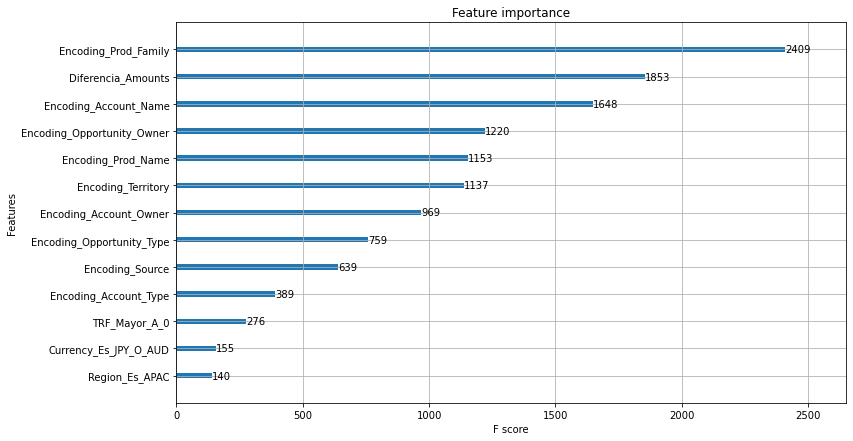

In [1313]:
plt.rcParams['figure.figsize'] = [12, 7]
xgb.plot_importance(xg_reg)